In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch

import eq 

# Create a new dataset for RECAST

In this notebook, we consider a dataset with times, magnitude and additional features (or marks). If you have your own dataset you can adapt this code block to your needs.

The format for extra features will be an np.array with shape `(n_events, n_marks)`. In this example, we will use a dataset with 3 marks (one of the marks will be magnitude), `extra_features` will have shape `(n_events, 2)`. 
 

In [2]:
# a time series of 1000 points:
t_start = 0
t_end = 100
duration = t_end - t_start
number_of_events = 1000
number_of_extra_features = 2 # add documentation
split = 0.8 # 80% of the data will be used for training, 20% for validation

# Create some events (time, magnitude) - these are random for illustration purposes only
event_times = np.sort(
    np.random.random(number_of_events) * duration + t_start
)
magnitudes = np.random.exponential(1/np.log(10),number_of_events) # exponential distribution with "Mc" = 0
magnitudes = eq.data.ContinuousMarks(magnitudes,[0,10])
# Create some extra features that the model will also use for estimation.
extra_features = np.random.random(
    (number_of_events,number_of_extra_features)
) * 2 - 1 # uniform distribution between -1 and 1

If you adapted the above and the following runs you are probably ready to go. 

The code block below tests if the data and variables are in the correct format.

In [3]:
assert extra_features.shape[0] == event_times.shape[0]
assert extra_features.shape[1] == number_of_extra_features
assert t_start <= event_times.min() <= event_times.max() <= t_end
assert split > 0 and split < 1
assert duration == t_end - t_start

### Notes about extra features:

**Support for this functionality is experimental and not explored in careful detail in the paper**. The user is responsible for making sure that the extra features are compatible with the model. For instance, the is no current support for sampling if using extra features.

Examples of extra features may include:
* source properties (depth, stress drop, focal mechanism, etc.)
* site properties (Vs30, thermal structure, etc.) 
* waveform features (ftt, rms, etc.) 
* categorical features (e.g. region, etc.) - use some encoding scheme (e.g. one-hot encoding)

Continuous time series data (e.g. injection rate, GPS, etc.) is not necessarily well suited for a point process model. The benefit of a point process model is to approximate a time series as a set of events. One could nonetheless consider a summary statistics of the time series up to the event in question included with each events as a set of marks.

**It is advisable to strandardize the extra features before using them in the model.** So the mean should be near zero and the variance near one. 

### Sequence, batches, and dataloaders

An `eq.data.Sequence` object contains the following attributes:
- `t_start` and `t_end`: Start and end of the time interval containing the events (in days).
- `arrival_times`: Arrival times of each event (in days), shape `[num_events]`
- `inter_times`: Inter-event times, shape `[num_events + 1]` since this also includes the last survival time from `arrival_times[-1]` until `t_end`.
- `mag`: Magnitude of each earthquake, shape `[num_events]`.
- `t_nll_start`: This attributed allows to compute the negative log-likelihood (NLL) only for the observations in the interval `[t_nll_start, t_end]`, while conditioning the model on past events in `[t_start, t_nll_start]`.

For this example, we keep things simple and do not use a `t_nll_start` that is different from `t_start`.

A variety of vizualization methods are available for `eq.data.Sequence` objects, including:

<Axes: xlabel='Time (days)', ylabel='Magnitude'>

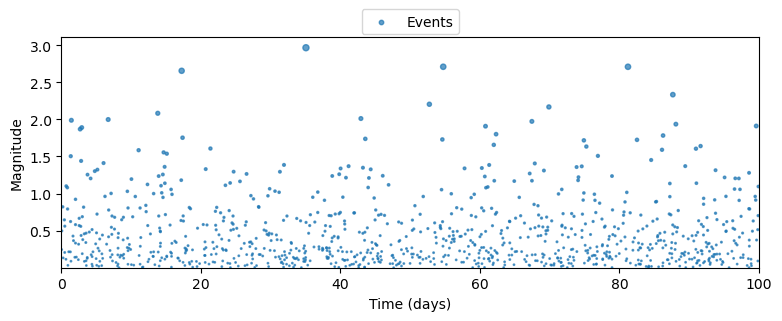

In [4]:
# create a sequence object:
inter_event_times = np.diff(event_times, prepend=t_start, append=t_end)
sequence = eq.data.Sequence(
    inter_times=torch.as_tensor(inter_event_times, dtype=torch.float32),
    t_start=t_start,
    t_end=t_end,
    mag = magnitudes,
    extra_feat = torch.as_tensor(extra_features,  dtype=torch.float32), # add new features
)

eq.visualization.visualize_sequence(sequence)

To compare different models, we split the full event sequence into a training and validation sets.

In [5]:

# split the sequence into training and validation:
train_sequence, val_sequence = [
    sequence.get_subsequence(start, end) 
    for start, end in [
        (t_start, t_start + split*duration), 
        (t_start + split*duration, t_end)
    ]
]


print("Train sequence:")
print(train_sequence)
print("Validation sequence:")
print(val_sequence)

Train sequence:
Sequence(
  inter_times: [793],
  arrival_times: [792],
  t_start: 0.0,
  t_end: 80.0,
  t_nll_start: 0.0,
  mag: [792],
  mag_bounds: [2],
  mag_nll_bounds: [2],
  extra_feat: [792, 2]
)
Validation sequence:
Sequence(
  inter_times: [209],
  arrival_times: [208],
  t_start: 80.0,
  t_end: 100.0,
  t_nll_start: 80.0,
  mag: [208],
  mag_bounds: [2],
  mag_nll_bounds: [2],
  extra_feat: [208, 2]
)


This time, we will train the model using a standard training loop just using `PyTorch`.

For this, we first need to create `torch.utils.data.DataLoader` objects that will feed the data into the model.

In [6]:
train_batch = eq.data.Batch.from_list([train_sequence])
val_batch = eq.data.Batch.from_list([val_sequence])

dl_train = torch.utils.data.DataLoader(train_batch, batch_size=1, shuffle=False)
dl_val = torch.utils.data.DataLoader(val_batch, batch_size=1, shuffle=False)

## Training the model

Now, we initialize the model.

In [7]:
model = eq.models.RecurrentTPP(
    num_extra_features=number_of_extra_features, # the number of extra features
    tau_mean=(
        len(train_sequence)/(train_sequence.t_end-train_sequence.t_start)
    ), # the mean of the inter-event time distribution
)

In [8]:
# Simple training loop in PyTorch
# takes ~ 15s on a GPU
epochs = 400

running_training_loss = []
running_validation_loss = []
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

for _ in range(epochs):
    optimizer.zero_grad()                           # zero the gradient buffers
    nll = model.nll_loss(train_batch)               # compute the loss
    nll.backward()                                  # compute the gradients
    optimizer.step()                                # update the weights
    running_training_loss.append(nll.item())        # save the training loss
    with torch.no_grad():                           # compute/save the validation loss
        nll_val = model.nll_loss(val_batch)
        running_validation_loss.append(nll_val.item())       

KeyboardInterrupt: 

## Evaluation

After training the model, we compute the loss on the negative log-likelihood (NLL) loss on the test set.

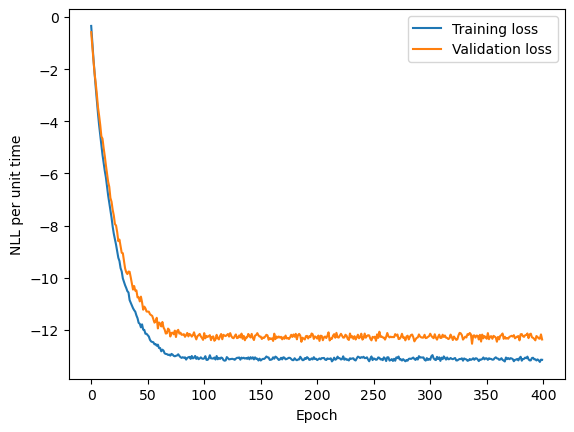

In [9]:
fig, ax = plt.subplots()
ax.plot(running_training_loss, label="Training loss")
ax.plot(running_validation_loss, label="Validation loss")
ax.legend()
ax.set(
    xlabel="Epoch",
    ylabel="NLL per unit time", 
);

Note that the models could be trained for more epochs until the loss on the validation set stops decreasing.